# Imports and Dataset Loading

In [47]:
# Imports
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


In [48]:
base_dir = Path(globals()["_dh"][0]).parent

DATASET_NAME = "healthcare-dataset-stroke-data.csv"
dataset_path = base_dir / "datasets" / DATASET_NAME

df = pd.read_csv(dataset_path)

# Initial analysis and data cleaning

In [49]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [50]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [51]:
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### Converting data that is not numerical to numerical and dropping NaN values

The algorithm needs numerical data to work, so we need to convert the data that is not numerical to numerical. We will use the `LabelEncoder` from `sklearn` to do this.

In [52]:
def string_convertor(df: pd.DataFrame, column: str) -> pd.DataFrame:
    unique_vals = df[column].unique()
    
    label_encoder = LabelEncoder()
    label_encoder.fit(unique_vals)
    
    df[column] = label_encoder.transform(df[column])
    return df

string_convertor(df, "gender")
string_convertor(df, "ever_married")
string_convertor(df, "work_type")
string_convertor(df, "Residence_type")
string_convertor(df, "smoking_status")

df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,1,67.0,0,1,1,2,1,228.69,36.6,1,1
1,51676,0,61.0,0,0,1,3,0,202.21,NaN,2,1
2,31112,1,80.0,0,1,1,2,0,105.92,32.5,2,1
3,60182,0,49.0,0,0,1,2,1,171.23,34.4,3,1
4,1665,0,79.0,1,0,1,3,0,174.12,24.0,2,1


Note that there are some NaN values in the dataset. We will drop them using the `dropna()` method from `pandas`.


In [53]:
df = df.dropna()

### Analyzing and correcting the balance of the dataset

Let's analyze the balance of the dataset. We will plot the number of samples for each class using `countplot` from `seaborn`.

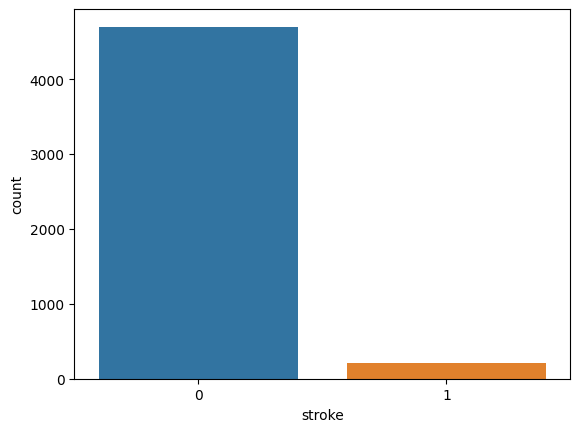

In [54]:
sns.countplot(x="stroke", data=df)
plt.show()


Note that the dataset is not balanced, so we will have to correct this by means of undersampling.

In [55]:
minority_data = df[df["stroke"] == 1]
majority_data = df[df["stroke"] == 0].sample(n=len(minority_data))

df = pd.concat([minority_data, majority_data])

# Classification algorithm

Lets split the dataset into training and testing sets using `train_test_split` from `sklearn`.

In [56]:
X = df.copy().drop("stroke", axis=1)
Y = df["stroke"]

In [57]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

Now, we need to find the best parameters for the algorithm.

We will use the `get_score_with_params` function to find the score for each combination of parameters.

We will then use `plot_parameter_scores` to plot the scores for each value of a parameter.

In [58]:
def get_score_with_params(X_train, X_test, Y_train, Y_test, **params):
    model = RandomForestClassifier(**params)
    model.fit(X_train, Y_train)
    return model.score(X_test, Y_test), model.score(X_train, Y_train)

In [59]:
def plot_parameter_scores(X_train, X_test, Y_train, Y_test, values, parameter):
    results_test = {}
    results_train = {}
    
    for value in values:
        score_test, score_train = get_score_with_params(X_train, X_test, Y_train, Y_test, **{parameter: value})
        results_test[value] = score_test
        results_train[value] = score_train
        
    plt.plot(results_test.keys(), results_test.values(), label="Test", color="red")
    plt.plot(results_train.keys(), results_train.values(), label="Train", color="blue")

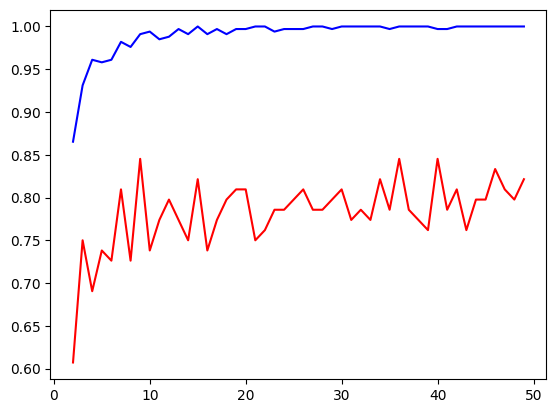

In [60]:
plot_parameter_scores(X_train, X_test, Y_train, Y_test, range(2, 50), "n_estimators")

From the above graph, we can see that the best value for `n_estimators` is 10.

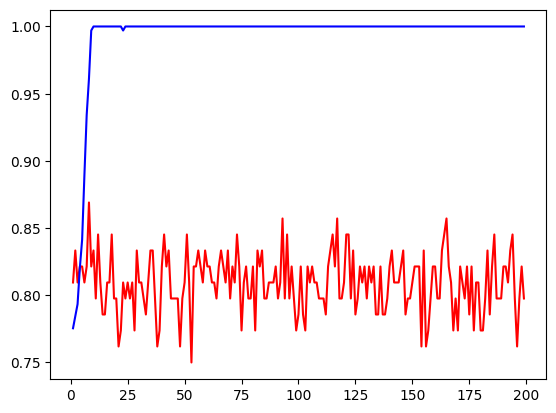

In [61]:
plot_parameter_scores(X_train, X_test, Y_train, Y_test, range(1, 200), "max_depth")

From the above graph, we can see that `max_depth` does not affect the score much, so we will use the default value of `None`.

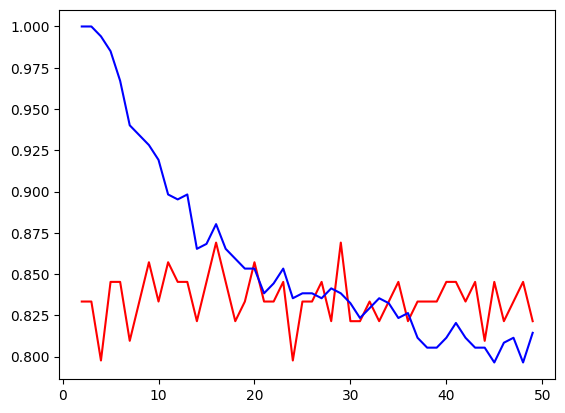

In [69]:
plot_parameter_scores(X_train, X_test, Y_train, Y_test, range(2, 50), "min_samples_split")

From the above graph, we can see that `min_samples_split` is acceptable with it's default value of 2.

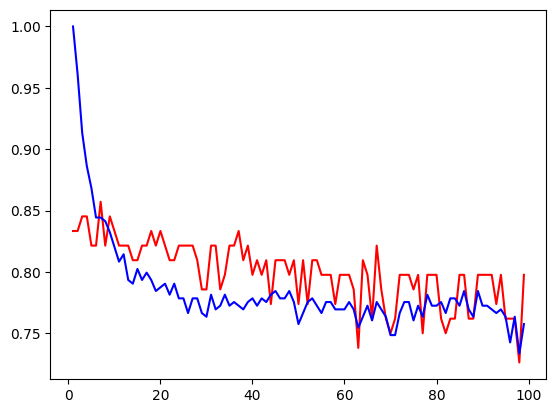

In [63]:
plot_parameter_scores(X_train, X_test, Y_train, Y_test, range(1, 100), "min_samples_leaf")

From the above graph, we can see that the best value for `min_samples_leaf` is 5.

We will therefore use the following parameters for our `RandomForestClassifier`:

- `n_estimators`: 10
- `min_samples_leaf`: 5

In [70]:
clf = RandomForestClassifier(criterion="log_loss", n_estimators=10, min_samples_leaf=5)

In [71]:
clf.fit(X_train, Y_train)

RandomForestClassifier(criterion='log_loss', min_samples_leaf=5,
                       n_estimators=10)

In [72]:
y_pred = clf.predict(X_test)

In [73]:
accuracy_score(Y_test, y_pred)

0.7857142857142857

In [74]:
print(classification_report(Y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.78      0.76        37
           1       0.82      0.79      0.80        47

    accuracy                           0.79        84
   macro avg       0.78      0.79      0.78        84
weighted avg       0.79      0.79      0.79        84



By analyzing the results above, we can see that the model has an accuracy of 72%.